**Coursework for 《Advances in Machine Learning》, 2025 Spring.**
***
This notebook demonstrates the implementation of [Trading financial indices with reinforcement learning agents](https://doi.org/10.1016/j.eswa.2018.02.032).

Our github repository is [here](https://github.com/FlyingParachute/MathFin_RL).

**Group members:** Jingtong Xu, Jinyi Lin, Sunqinli Wang, Xingjian Zhao.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from IPython.display import display, HTML

# 0 Parameter setting (same as the paper)

In [2]:
gamma   = 0.9
lambda_ = 0.9
alpha   = 0.1
epsilon = 0.01
eta     = 0.1

column_names = {
    'ptf1': {
        'quarterly':  {'spx': 'SPXret_1q', 'agg': 'AGGret_1q'},
        'semi_annual':{'spx': 'SPXret_s',  'agg': 'AGGret_s'},
        'annual':     {'spx': 'SPXret_a',  'agg': 'AGGret_a'}
    },
    'ptf3': {
        'quarterly':  {'spx': 'SPXret_1q', 'agg': 'TNXret_q'},
        'semi_annual':{'spx': 'SPXret_s',  'agg': 'TNXret_s'},
        'annual':     {'spx': 'SPXret_a',  'agg': 'TNXret_a'}
    }
}

# 1 Load and Prepare Data

## 1.1 Load Data

**Portfolios 1**: the combination of SPX and AGG;

**Portfolio 2**: the combination of SPX and T-NOTE 10YR.

In [3]:
def load_ptf1_annual():
    """
    Load SPX and AGG data
    read Portfolio_1.xlsx annual data and set 'Dates' column as index.
    """
    file_path = '../data/processed/Portfolio_1.xlsx'
    sheets = ['Quarterly', 'Semi Annually', 'Yearly']
    ptf1 = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets}
    return ptf1['Yearly'].set_index('Dates')

def load_ptf1_semi_annual():
    """
    Load SPX and AGG data
    read Portfolio_1.xlsx semi-annual data and set 'Dates' column as index.
    """
    file_path = '../data/processed/Portfolio_1.xlsx'
    sheets = ['Quarterly', 'Semi Annually', 'Yearly']
    ptf1 = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets}
    return ptf1['Semi Annually'].set_index('Dates')

def load_ptf1_quarterly():
    """
    Load SPX and AGG data
    read Portfolio_1.xlsx quarterly data and set 'Dates' column as index.
    """
    file_path = '../data/processed/Portfolio_1.xlsx'
    sheets = ['Quarterly', 'Semi Annually', 'Yearly']
    ptf1 = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets}
    return ptf1['Quarterly'].set_index('Dates')

def load_ptf3_annual():
    """
    Load SPX and TNOTE data
    read Portfolio_3.xlsx annual data and set 'Dates' column as index.
    """
    file_path = '../data/processed/Portfolio_3.xlsx'
    sheets = ['Quarterly', 'Semi Annually', 'Yearly']
    ptf3 = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets}
    return ptf3['Yearly'].set_index('Dates')

def load_ptf3_semi_annual():
    """
    Load SPX and TNOTE data
    read Portfolio_3.xlsx semi-annual data and set 'Dates' column as index.
    """
    file_path = '../data/processed/Portfolio_3.xlsx'
    sheets = ['Quarterly', 'Semi Annually', 'Yearly']
    ptf3 = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets}
    return ptf3['Semi Annually'].set_index('Dates')

def load_ptf3_quarterly():
    """
    Load SPX and TNOTE data
    read Portfolio_3.xlsx quarterly data and set 'Dates' column as index.
    """
    file_path = '../data/processed/Portfolio_3.xlsx'
    sheets = ['Quarterly', 'Semi Annually', 'Yearly']
    ptf3 = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets}
    return ptf3['Quarterly'].set_index('Dates')

## 1.2 Define the State Space

In [4]:
def get_state(spx_ret, agg_ret):
    """Convert positive and negative returns of spx and agg to binary states."""
    s = ''
    s += '1' if spx_ret >= 0 else '0'
    s += '1' if agg_ret >= 0 else '0'
    return s

# 2 Action Space

| Action | 1      | 2      | 3      | 4      | 5      |
|--------|--------|--------|--------|--------|--------|
| **S&P 500 (%)** | 0      | 25     | 50     | 75     | 100    |
| **AGG or T-bill bond (%)** | 100    | 75     | 50     | 25     | 0      |

In [5]:

# Discrete action space (stock proportion)
actions = [0.0, 0.25, 0.5, 0.75, 1.0]

def initialize_q():
    """Initialize Q matrix (4 states x 5 actions)."""
    states = ['11', '01', '10', '00']
    return pd.DataFrame(np.random.rand(4, 5), index=states, columns=actions)

# 3 Train the Agent

## 3.1 Define the Agent

In [6]:
class SarsaLambdaAgent:
    """
    SARSA(λ) discrete action agent.
    reward_type='return' or 'sharpe'.
    """
    def __init__(self, reward_type='return'):
        self.q = initialize_q()
        self.e = pd.DataFrame(np.zeros((4, 5)), index=self.q.index, columns=self.q.columns)
        self.reward_type = reward_type
        self.A = 0  # First moment for differential Sharpe ratio
        self.B = 0  # Second moment for differential Sharpe ratio

    def get_reward(self, spx_ret, agg_ret, action):
        portfolio_ret = action * spx_ret + (1 - action) * agg_ret
        
        if self.reward_type == 'return':
            return portfolio_ret
        else:  # sharpe
            # 使用旧的A、B计算差分夏普比率
            old_A = self.A
            old_B = self.B
            denominator = (old_B - old_A**2)**1.5
            
            if denominator == 0:
                dsr = 0
            else:
                dsr = (old_B * (portfolio_ret - old_A) - 0.5 * old_A * (portfolio_ret**2 - old_B)) / denominator
            
            # 更新A、B
            self.A = old_A + eta * (portfolio_ret - old_A)
            self.B = old_B + eta * (portfolio_ret**2 - old_B)
            return dsr

    def update(self, state, action, reward, next_state, next_action):
        # Calculate TD error
        delta = reward + gamma * self.q.loc[next_state, next_action] - self.q.loc[state, action]
        
        # Replace trace update - set current state-action pair to 1
        self.e.loc[state, action] = 1
        
        # Update Q values
        for s in self.q.index:
            for a in self.q.columns:
                self.q.loc[s, a] += alpha * delta * self.e.loc[s, a]
        
        # Decay all eligibility traces
        self.e = gamma * lambda_ * self.e

    def choose_action(self, state):
        if np.random.rand() < epsilon:
            return np.random.choice(actions)
        else:
            return self.q.loc[state].idxmax()

class QLambdaAgent(SarsaLambdaAgent):
    """
    Q(λ) discrete action agent.
    reward_type='return' or 'sharpe'.
    """
    def __init__(self, reward_type='return'):
        super().__init__(reward_type)

    def update(self, state, action, reward, next_state):
        # Find the action with maximum Q value for the next state
        a_star = self.q.loc[next_state].idxmax()
        
        # Calculate TD error
        delta = reward + gamma * self.q.loc[next_state, a_star] - self.q.loc[state, action]
        
        # Set eligibility trace for the current state-action pair to 1
        self.e.loc[state, action] = 1
        
        # Update Q values
        for s in self.q.index:
            for a in self.q.columns:
                self.q.loc[s, a] += alpha * delta * self.e.loc[s, a]
        
        # Update eligibility traces based on greedy action
        # If the next action is not greedy, zero all eligibility traces
        next_action = self.choose_action(next_state)
        if next_action != a_star:
            self.e = 0 * self.e
        else:
            self.e = gamma * lambda_ * self.e

class TDContinuousAgent:
    """
    TD(λ) continuous action agent (two assets).
    """
    def __init__(self):
        # Each state has theta=[theta1, theta2], theta1 in [0,1] represents stock proportion
        states = ['11', '01', '10', '00']
        self.theta = {s: [np.random.uniform(0, 1), 0] for s in states}
        self.e_trace = {s: [0, 0] for s in states}

    def get_value(self, state, spx_ret, agg_ret):
        """Calculate the value function for the current state."""
        # V(s) = θ₁ᴱ(R_t^S - R_t^B) + θ₂ᴱ
        return self.theta[state][0] * (spx_ret - agg_ret) + self.theta[state][1]

    def get_allocation(self, state):
        """Return stock allocation proportion based on current state."""
        if np.random.rand() < epsilon:
            # Exploration: return a random value between [0,1]
            return np.random.uniform(0, 1)
        else:
            # Exploitation: return the θ₁ value for the current state
            return np.clip(self.theta[state][0], 0, 1)

    def update(self, state, spx_ret, agg_ret, reward, next_state):
        # Calculate value functions for current and next states
        current_value = self.get_value(state, spx_ret, agg_ret)
        next_value = self.get_value(next_state, spx_ret, agg_ret)
        
        # Calculate TD error
        delta = reward + gamma * next_value - current_value
        
        # Update eligibility trace: e = γλe + ∇θV(s)
        gradient = [spx_ret - agg_ret, 1]  # ∇θV(s) = (R_t^S - R_t^B, 1)^T
        for i in range(2):
            self.e_trace[state][i] = gamma * lambda_ * self.e_trace[state][i] + gradient[i]
        
        # Update parameters: θ = θ + αδe
        for i in range(2):
            self.theta[state][i] += alpha * delta * self.e_trace[state][i]
        
        # Constrain θ₁ to the [0,1] interval
        self.theta[state][0] = np.clip(self.theta[state][0], 0, 1)


## 3.2 Backtest Function

In [7]:
def backtest(data, train_end_date, test_end_date,
             agent_type='sarsa', reward_type='return',
             freq='annual', portfolio='ptf1'):
    """
    Static Knowledge Agents (SKAs).
    """
    spx_col = column_names[portfolio][freq]['spx']
    agg_col = column_names[portfolio][freq]['agg']

    if isinstance(train_end_date, str):
        train_end_date = pd.to_datetime(train_end_date)
    if isinstance(test_end_date, str):
        test_end_date = pd.to_datetime(test_end_date)

    train_data = data[data.index <= train_end_date]
    test_data = data[(data.index > train_end_date) & (data.index <= test_end_date)]

    # Initialize agent
    if agent_type == 'continuous':
        agent = TDContinuousAgent()
    elif agent_type == 'sarsa':
        agent = SarsaLambdaAgent(reward_type=reward_type)
    elif agent_type == 'qlearning':
        agent = QLambdaAgent(reward_type=reward_type)

    # Training phase: multiple episodes with randomized initial states
    num_episodes = 10
    min_ep_len = 4
    for _ in range(num_episodes):
        # Randomly select starting point
        start_idx = np.random.randint(0, max(1, len(train_data) - min_ep_len))
        
        # Reset eligibility traces
        if agent_type == 'continuous':
            agent.e_trace = {s: [0, 0] for s in agent.e_trace}
        else:
            agent.e = pd.DataFrame(np.zeros((4, 5)), index=agent.q.index, columns=agent.q.columns)
            
        for i in range(start_idx + 1, len(train_data)):
            prev_row = train_data.iloc[i - 1]
            curr_row = train_data.iloc[i]
            state = get_state(prev_row[spx_col], prev_row[agg_col])

            if agent_type == 'continuous':
                action = agent.get_allocation(state)
            else:
                action = agent.choose_action(state)

            # Calculate reward
            if agent_type in ['sarsa', 'qlearning'] and reward_type == 'sharpe':
                reward = agent.get_reward(curr_row[spx_col], curr_row[agg_col], action)
            else:
                portfolio_ret = action * curr_row[spx_col] + (1 - action) * curr_row[agg_col]
                reward = portfolio_ret

            next_state = get_state(curr_row[spx_col], curr_row[agg_col])

            if agent_type == 'sarsa':
                next_action = agent.choose_action(next_state)
                agent.update(state, action, reward, next_state, next_action)
            elif agent_type == 'qlearning':
                agent.update(state, action, reward, next_state)
            elif agent_type == 'continuous':
                agent.update(state, curr_row[spx_col], curr_row[agg_col], reward, next_state)

    # Testing phase
    portfolio_values = [10000]
    current_value = 10000
    dates = [train_end_date]

    for i in range(len(test_data)):
        if i == 0:
            prev_row = train_data.iloc[-1]
        else:
            prev_row = test_data.iloc[i - 1]
        curr_row = test_data.iloc[i]

        state = get_state(prev_row[spx_col], prev_row[agg_col])
        if agent_type == 'continuous':
            action = agent.get_allocation(state)
        else:
            action = agent.choose_action(state)

        ret = action * curr_row[spx_col] + (1 - action) * curr_row[agg_col]
        current_value *= (1 + ret)
        portfolio_values.append(current_value)
        dates.append(test_data.index[i])

    return portfolio_values, dates

def backtest_AKA(data, train_end_date, test_end_date,
                 agent_type='sarsa', reward_type='return',
                 freq='annual', portfolio='ptf1'):
    """
    Adaptive Knowledge Agents (AKAs).
    """
    spx_col = column_names[portfolio][freq]['spx']
    agg_col = column_names[portfolio][freq]['agg']

    full_data = pd.concat([
        data[data.index <= train_end_date],
        data[(data.index > train_end_date) & (data.index <= test_end_date)]
    ])

    portfolio_values = [10000]
    dates = [train_end_date]

    for current_date in full_data[full_data.index > train_end_date].index:
        current_train_data = full_data[full_data.index < current_date]

        # Reinitialize agent each time
        if agent_type == 'continuous':
            agent = TDContinuousAgent()
        elif agent_type == 'sarsa':
            agent = SarsaLambdaAgent(reward_type=reward_type)
        elif agent_type == 'qlearning':
            agent = QLambdaAgent(reward_type=reward_type)

        # Training
        num_episodes = 10  # Increase number of iterations
        min_ep_len = 4
        if len(current_train_data) > min_ep_len:
            for _ in range(num_episodes):
                start_idx = np.random.randint(0, len(current_train_data) - min_ep_len)
                
                # Reset eligibility traces
                if agent_type == 'continuous':
                    agent.e_trace = {s: [0, 0] for s in agent.e_trace}
                else:
                    agent.e = pd.DataFrame(np.zeros((4, 5)), index=agent.q.index, columns=agent.q.columns)
                    
                for i in range(start_idx + 1, len(current_train_data)):
                    prev_row = current_train_data.iloc[i - 1]
                    curr_row = current_train_data.iloc[i]
                    state = get_state(prev_row[spx_col], prev_row[agg_col])

                    if agent_type == 'continuous':
                        action = agent.get_allocation(state)
                    else:
                        action = agent.choose_action(state)

                    if agent_type in ['sarsa', 'qlearning'] and reward_type == 'sharpe':
                        reward = agent.get_reward(curr_row[spx_col], curr_row[agg_col], action)
                    else:
                        portfolio_ret = action * curr_row[spx_col] + (1 - action) * curr_row[agg_col]
                        reward = portfolio_ret

                    next_state = get_state(curr_row[spx_col], curr_row[agg_col])

                    if agent_type == 'sarsa':
                        next_action = agent.choose_action(next_state)
                        agent.update(state, action, reward, next_state, next_action)
                    elif agent_type == 'qlearning':
                        agent.update(state, action, reward, next_state)
                    elif agent_type == 'continuous':
                        agent.update(state, curr_row[spx_col], curr_row[agg_col], reward, next_state)

        # Test current point
        prev_row = current_train_data.iloc[-1] if len(current_train_data) > 0 else full_data.iloc[0]
        current_row = full_data.loc[current_date]
        state = get_state(prev_row[spx_col], prev_row[agg_col])

        if agent_type == 'continuous':
            action = agent.get_allocation(state)
        else:
            action = agent.choose_action(state)

        ret = action * current_row[spx_col] + (1 - action) * current_row[agg_col]
        portfolio_values.append(portfolio_values[-1] * (1 + ret))
        dates.append(current_date)

    return portfolio_values, dates


## 3.3 Function for visualizing the backtest results

In [8]:
def annualized_returns(final_val, start_date, end_date):  
    """
    Calculate total return and annualized return.
    
    Parameters:
    final_val (float): Final portfolio value.
    start_date (pd.Timestamp): Start date of the investment period.
    end_date (pd.Timestamp): End date of the investment period.
    
    Returns:
    tuple: (total return (%), annualized return (%), investment years)
    """
    years = (end_date - start_date).days / 365.25
    total_ret = (final_val / 10000 - 1) * 100
    ann_ret = ((final_val / 10000) ** (1 / years) - 1) * 100
    return total_ret, ann_ret, years

def compute_sharpe_ratio(portfolio_values, freq='annual'):
    """
    Compute the Sharpe ratio assuming a risk-free rate of 0.
    
    Parameters:
    portfolio_values (list or np.array): Sequence of portfolio values.
    freq (str): Frequency of returns ('annual', 'quarterly', or 'semi-annual').
    
    Returns:
    float: Sharpe ratio.
    """
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    if freq == 'quarterly':
        multiplier = np.sqrt(4)
    elif freq == 'semi-annual':
        multiplier = np.sqrt(2)
    else:
        multiplier = 1  # Annual
    
    std = np.std(returns)
    if std == 0:
        sharpe = np.nan
    else:
        sharpe = np.mean(returns) / std * multiplier
    return sharpe

def compute_max_drawdown(portfolio_values):
    """
    Compute the maximum drawdown.
    
    Parameters:
    portfolio_values (list or np.array): Sequence of portfolio values.
    
    Returns:
    float: Maximum drawdown (negative value).
    """
    pvals = np.array(portfolio_values)
    peak = np.maximum.accumulate(pvals)
    drawdowns = (pvals - peak) / peak
    max_drawdown = drawdowns.min()
    return max_drawdown


In [9]:
def calculate_benchmarks(data, train_end_date, test_end_date,
                         freq='annual', portfolio='ptf1'):
    spx_col = column_names[portfolio][freq]['spx']
    agg_col = column_names[portfolio][freq]['agg']

    test_data = data[(data.index > train_end_date) & (data.index <= test_end_date)]

    allocations = {
        'A2': 0.25,
        'A3': 0.5,
        'A4': 0.75,
        'Bonds': 0.0,
        'Stocks': 1.0
    }
    # Ceiling strategy
    benchmarks = {k: [10000] for k in allocations}
    benchmarks['Ceiling'] = [10000]

    for i in range(len(test_data)):
        spx_ret = test_data.iloc[i][spx_col]
        agg_ret = test_data.iloc[i][agg_col]
        for strategy, alloc in allocations.items():
            ret = alloc * spx_ret + (1 - alloc) * agg_ret
            benchmarks[strategy].append(benchmarks[strategy][-1] * (1 + ret))
        best_ret = max(spx_ret, agg_ret)
        benchmarks['Ceiling'].append(benchmarks['Ceiling'][-1] * (1 + best_ret))
    return benchmarks

def plot_fig4_5(data, train_start_str, train_end_str, test_start_str, test_end_str,
                freq='annual', portfolio='ptf1', fig_title_prefix=''):
    """
    Fig.4: On-policy(SARSA) & Continuous
    Fig.5: Off-policy(Q-learning)
    Training period: [train_start, train_end]
    Testing period: (train_end, test_end]
    """

    was_interactive = plt.isinteractive()
    plt.ioff()  

    train_start = pd.to_datetime(train_start_str)
    train_end   = pd.to_datetime(train_end_str)
    test_start  = pd.to_datetime(test_start_str)
    test_end    = pd.to_datetime(test_end_str)

    full_data = data[(data.index >= train_start) & (data.index <= test_end)]
    benchmarks = calculate_benchmarks(full_data, train_end, test_end, freq, portfolio)

    # Fig.4: On-policy & Continuous
    ska_vals, ska_dates = backtest(full_data, train_end, test_end,
                                   agent_type='sarsa', reward_type='return',
                                   freq=freq, portfolio=portfolio)
    aka_vals, aka_dates = backtest_AKA(full_data, train_end, test_end,
                                       agent_type='sarsa', reward_type='return',
                                       freq=freq, portfolio=portfolio)
    s_ska_vals, _ = backtest(full_data, train_end, test_end,
                             agent_type='sarsa', reward_type='sharpe',
                             freq=freq, portfolio=portfolio)
    s_aka_vals, _ = backtest_AKA(full_data, train_end, test_end,
                                 agent_type='sarsa', reward_type='sharpe',
                                 freq=freq, portfolio=portfolio)
    ca_ska_vals, _ = backtest(full_data, train_end, test_end,
                              agent_type='continuous', reward_type='return',
                              freq=freq, portfolio=portfolio)
    ca_aka_vals, _ = backtest_AKA(full_data, train_end, test_end,
                                  agent_type='continuous', reward_type='return',
                                  freq=freq, portfolio=portfolio)

    fig4 = plt.figure(figsize=(10, 6))
    ax4 = fig4.add_subplot(111)
    ax4.plot(ska_dates, ska_vals,   label='SKA (R-SKA)', linewidth=2)
    ax4.plot(aka_dates, aka_vals,   label='AKA (R-AKA)', linewidth=2)
    ax4.plot(ska_dates, s_ska_vals, label='S-SKA',       linewidth=2)
    ax4.plot(ska_dates, s_aka_vals, label='S-AKA',       linewidth=2)
    ax4.plot(ska_dates, ca_ska_vals,label='CA-SKA',      linewidth=2)
    ax4.plot(ska_dates, ca_aka_vals,label='CA-AKA',      linewidth=2)
    ax4.plot(ska_dates, benchmarks['Bonds'],  label='AGG Bonds', linestyle='--')
    ax4.plot(ska_dates, benchmarks['Stocks'], label='S&P 500',   linestyle='--')
    ax4.plot(ska_dates, benchmarks['Ceiling'],label='Ceiling',   linestyle='-.')
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc='upper left')
    ax4.set_title(f'{fig_title_prefix}Portfolio Performance: On-policy & Continuous Agents')
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    fig4.autofmt_xdate()
    ax4.set_ylabel('Portfolio Value ($)')
    ax4.set_xlabel('Year')
    fig4.tight_layout()

    # Fig.5: Off-policy
    q_ska_vals, q_ska_dates = backtest(full_data, train_end, test_end,
                                       agent_type='qlearning', reward_type='return',
                                       freq=freq, portfolio=portfolio)
    q_aka_vals, _ = backtest_AKA(full_data, train_end, test_end,
                                 agent_type='qlearning', reward_type='return',
                                 freq=freq, portfolio=portfolio)
    qs_ska_vals, _ = backtest(full_data, train_end, test_end,
                              agent_type='qlearning', reward_type='sharpe',
                              freq=freq, portfolio=portfolio)
    qs_aka_vals, _ = backtest_AKA(full_data, train_end, test_end,
                                  agent_type='qlearning', reward_type='sharpe',
                                  freq=freq, portfolio=portfolio)

    fig5 = plt.figure(figsize=(10, 6))
    ax5 = fig5.add_subplot(111)
    ax5.plot(q_ska_dates, benchmarks['Bonds'],  label='Bonds',  linestyle='--')
    ax5.plot(q_ska_dates, benchmarks['Stocks'], label='Stocks', linestyle='--')
    ax5.plot(q_ska_dates, q_ska_vals,   label='Q-SKA',   linewidth=2)
    ax5.plot(q_ska_dates, q_aka_vals,   label='Q-AKA',   linewidth=2)
    ax5.plot(q_ska_dates, qs_ska_vals,  label='QS-SKA',  linewidth=2)
    ax5.plot(q_ska_dates, qs_aka_vals,  label='QS-AKA',  linewidth=2)
    ax5.plot(q_ska_dates, benchmarks['A2'], label='A2', linestyle=':')
    ax5.plot(q_ska_dates, benchmarks['A3'], label='A3', linestyle=':')
    ax5.plot(q_ska_dates, benchmarks['A4'], label='A4', linestyle=':')
    ax5.grid(True, alpha=0.3)
    ax5.legend(loc='upper left')
    ax5.set_title(f'{fig_title_prefix}Portfolio Performance: Off-policy Agents')
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    fig5.autofmt_xdate()
    ax5.set_ylabel('Portfolio Value ($)')
    ax5.set_xlabel('Year')
    fig5.tight_layout()

    if was_interactive:
        plt.ion()
    else:
        plt.ioff()

    return fig4, fig5

def plot_fig6_7(data, train_start_str, train_end_str, test_start_str, test_end_str,
                freq='annual', portfolio='ptf1', fig_title_prefix=''):
    """
    Fig.6: On-policy & Continuous (second training/testing period)
    Fig.7: Off-policy (second training/testing period)
    """

    was_interactive = plt.isinteractive()
    plt.ioff()  

    fig6, fig7 = plot_fig4_5(data, train_start_str, train_end_str, test_start_str, test_end_str,
                             freq, portfolio, fig_title_prefix='Portfolio Performance: Second Period - ')
    

    fig6.axes[0].set_title(f'{fig_title_prefix}Portfolio Performance: On-policy & Continuous Agents (Second Period)')
    fig7.axes[0].set_title(f'{fig_title_prefix}Portfolio Performance: Off-policy Agents (Second Period)')
    
    if was_interactive:
        plt.ion()
    else:
        plt.ioff()

    return fig6, fig7

def plot_fig8_9(data, train_start_str, train_end_str, test_start_str, test_end_str,
                freq='annual', portfolio='ptf3', fig_title_prefix=''):
    """
    Fig.8: On-policy(SARSA) & Continuous
    Fig.9: Off-policy(Q-learning)
    Training period: [train_start, train_end]
    Testing period: (train_end, test_end]
    Saves all algorithm performance metrics in CSV: fig8_9_{freq}.csv
    """

    was_interactive = plt.isinteractive()
    plt.ioff() 

    train_start = pd.to_datetime(train_start_str)
    train_end   = pd.to_datetime(train_end_str)
    test_start  = pd.to_datetime(test_start_str)
    test_end    = pd.to_datetime(test_end_str)

    full_data = data[(data.index >= train_start) & (data.index <= test_end)]
    benchmarks = calculate_benchmarks(full_data, train_end, test_end, freq, portfolio)

    # Fig.8: On-policy & Continuous
    ska_vals, ska_dates = backtest(full_data, train_end, test_end,
                                   agent_type='sarsa', reward_type='return',
                                   freq=freq, portfolio=portfolio)
    aka_vals, aka_dates = backtest_AKA(full_data, train_end, test_end,
                                       agent_type='sarsa', reward_type='return',
                                       freq=freq, portfolio=portfolio)
    s_ska_vals, _ = backtest(full_data, train_end, test_end,
                             agent_type='sarsa', reward_type='sharpe',
                             freq=freq, portfolio=portfolio)
    s_aka_vals, _ = backtest_AKA(full_data, train_end, test_end,
                                 agent_type='sarsa', reward_type='sharpe',
                                 freq=freq, portfolio=portfolio)
    ca_ska_vals, _ = backtest(full_data, train_end, test_end,
                              agent_type='continuous', reward_type='return',
                              freq=freq, portfolio=portfolio)
    ca_aka_vals, _ = backtest_AKA(full_data, train_end, test_end,
                                  agent_type='continuous', reward_type='return',
                                  freq=freq, portfolio=portfolio)
    
    # Compute and store performance metrics for Figure 8
    fig8_labels_vals = {
        'SKA (R-SKA)':       ska_vals,
        'AKA (R-AKA)':       aka_vals,
        'S-SKA':             s_ska_vals,
        'S-AKA':             s_aka_vals,
        'CA-SKA':            ca_ska_vals,
        'CA-AKA':            ca_aka_vals,
        'T-NOTE':            benchmarks['Bonds'],
        'S&P 500':           benchmarks['Stocks'],
        'Ceiling':           benchmarks['Ceiling'],
    }

    results_fig8 = []
    for label_, vals_ in fig8_labels_vals.items():
        final_val = vals_[-1]
        total_ret, ann_ret, years = annualized_returns(final_val, pd.to_datetime(ska_dates[0]), pd.to_datetime(ska_dates[-1]))
        sharpe_ = compute_sharpe_ratio(vals_, freq)
        max_dd_ = compute_max_drawdown(vals_)

        results_fig8.append({
            'Figure': 'Fig.8',
            'Algorithm': label_,
            'TotalReturn(%)': f"{total_ret:.2f}",
            'Annualized(%)': f"{ann_ret:.2f}",
            'Sharpe': f"{sharpe_:.2f}" if sharpe_ is not None else "NaN",
            'MaxDD': f"{max_dd_:.2%}"
        })

    fig8 = plt.figure(figsize=(10, 6))
    ax8 = fig8.add_subplot(111)
    ax8.plot(ska_dates, ska_vals,   label='SKA (R-SKA)', linewidth=2)
    ax8.plot(aka_dates, aka_vals,   label='AKA (R-AKA)', linewidth=2)
    ax8.plot(ska_dates, s_ska_vals, label='S-SKA',       linewidth=2)
    ax8.plot(ska_dates, s_aka_vals, label='S-AKA',       linewidth=2)
    ax8.plot(ska_dates, ca_ska_vals,label='CA-SKA',      linewidth=2)
    ax8.plot(ska_dates, ca_aka_vals,label='CA-AKA',      linewidth=2)
    ax8.plot(ska_dates, benchmarks['Bonds'],  label='T-NOTE', linestyle='--')
    ax8.plot(ska_dates, benchmarks['Stocks'], label='S&P 500',   linestyle='--')
    ax8.plot(ska_dates, benchmarks['Ceiling'],label='Ceiling',   linestyle='-.')
    ax8.grid(True, alpha=0.3)
    ax8.legend(loc='upper left')
    ax8.set_title(f'{fig_title_prefix}Portfolio Performance: On-policy & Continuous Agents')
    ax8.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    fig8.autofmt_xdate()
    ax8.set_ylabel('Portfolio Value ($)')
    ax8.set_xlabel('Year')
    fig8.tight_layout()

    # Fig.9: Off-policy
    q_ska_vals, q_ska_dates = backtest(full_data, train_end, test_end,
                                       agent_type='qlearning', reward_type='return',
                                       freq=freq, portfolio=portfolio)
    q_aka_vals, _ = backtest_AKA(full_data, train_end, test_end,
                                 agent_type='qlearning', reward_type='return',
                                 freq=freq, portfolio=portfolio)
    qs_ska_vals, _ = backtest(full_data, train_end, test_end,
                              agent_type='qlearning', reward_type='sharpe',
                              freq=freq, portfolio=portfolio)
    qs_aka_vals, _ = backtest_AKA(full_data, train_end, test_end,
                                  agent_type='qlearning', reward_type='sharpe',
                                  freq=freq, portfolio=portfolio)
    
    # Compute and store performance metrics for Figure 9
    fig9_labels_vals = {
        'T-NOTE':   benchmarks['Bonds'],
        'Stocks':   benchmarks['Stocks'],
        'Q-SKA':    q_ska_vals,
        'Q-AKA':    q_aka_vals,
        'QS-SKA':   qs_ska_vals,
        'QS-AKA':   qs_aka_vals,
        'A2':       benchmarks['A2'],
        'A3':       benchmarks['A3'],
        'A4':       benchmarks['A4']
    }

    results_fig9 = []
    for label_, vals_ in fig9_labels_vals.items():
        final_val = vals_[-1]
        total_ret, ann_ret, years = annualized_returns(final_val, pd.to_datetime(q_ska_dates[0]), pd.to_datetime(q_ska_dates[-1]))
        sharpe_ = compute_sharpe_ratio(vals_, freq)
        max_dd_ = compute_max_drawdown(vals_)
        results_fig9.append({
            'Figure': 'Fig.9',
            'Algorithm': label_,
            'TotalReturn(%)': f"{total_ret:.2f}",
            'Annualized(%)': f"{ann_ret:.2f}",
            'Sharpe': f"{sharpe_:.2f}" if sharpe_ is not None else "NaN",
            'MaxDD': f"{max_dd_:.2%}"
        })



    fig9 = plt.figure(figsize=(10, 6))
    ax9 = fig9.add_subplot(111)
    ax9.plot(q_ska_dates, benchmarks['Bonds'],  label='T-NOTE',  linestyle='--')
    ax9.plot(q_ska_dates, benchmarks['Stocks'], label='Stocks', linestyle='--')
    ax9.plot(q_ska_dates, q_ska_vals,   label='Q-SKA',   linewidth=2)
    ax9.plot(q_ska_dates, q_aka_vals,   label='Q-AKA',   linewidth=2)
    ax9.plot(q_ska_dates, qs_ska_vals,  label='QS-SKA',  linewidth=2)
    ax9.plot(q_ska_dates, qs_aka_vals,  label='QS-AKA',  linewidth=2)
    ax9.plot(q_ska_dates, benchmarks['A2'], label='A2', linestyle=':')
    ax9.plot(q_ska_dates, benchmarks['A3'], label='A3', linestyle=':')
    ax9.plot(q_ska_dates, benchmarks['A4'], label='A4', linestyle=':')
    ax9.grid(True, alpha=0.3)
    ax9.legend(loc='upper left')
    ax9.set_title(f'{fig_title_prefix}Portfolio Performance: Off-policy Agents')
    ax9.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    fig9.autofmt_xdate()
    ax9.set_ylabel('Portfolio Value ($)')
    ax9.set_xlabel('Year')
    fig9.tight_layout()

    results_all = results_fig8 + results_fig9
    df_results = pd.DataFrame(results_all)
    csv_filename = f"ptf2_{freq}.csv"
    df_results.to_csv('../results/table/' + csv_filename, index=False)
    print(f"{csv_filename}" + " saved.")


    if was_interactive:
        plt.ion()
    else:
        plt.ioff()

    return fig8, fig9


# 4 Results

|               | SARSA(λ)        |               |               |               | Q(λ)           |               |               |               | TD(λ)          |               |
|---------------|-----------------|---------------|---------------|---------------|----------------|---------------|---------------|---------------|----------------|---------------|
| **Sub-column**| r-ska | r-aka | s-ska | s-aka | q-ska | q-aka | qs-ska | qs-aka | ca-ska | ca-aka |
|---------------|-------|-------|-------|-------|-------|-------|--------|--------|--------|--------|
| **Metric**    | Return| Return| Sharp | Sharp | Return| Return| Sharp  | Sharp  | Sharp  | Sharp  |
| **Static**    | ✓     | ✗     | ✓     | ✗     | ✓     | ✗     | ✓      | ✗      | ✓      | ✗      |
| **Cont.**     | ✗     | ✗     | ✗     | ✗     | ✗     | ✗     | ✗      | ✗      | ✓      | ✓      |

*Table: Comparison of Agent Types and Metrics*

In [20]:
ptf1_annual = load_ptf1_annual()
ptf1_semi_annual = load_ptf1_semi_annual()
ptf1_quarterly = load_ptf1_quarterly()
ptf3_annual = load_ptf3_annual()
ptf3_semi_annual = load_ptf3_semi_annual()
ptf3_quarterly = load_ptf3_quarterly()

figures_dir = '../results/figure/'
table_dir = '../results/table/'

In [11]:
fig4, fig5 = plot_fig4_5(
        data=ptf1_annual,
        train_start_str='1976-01-01',
        train_end_str='2001-12-31',
        test_start_str='2002-01-01',
        test_end_str='2016-12-31',
        freq='annual',
        portfolio='ptf1',
        fig_title_prefix=''
    )


fig6, fig7 = plot_fig6_7(
        data=ptf1_annual,
        train_start_str='1976-01-01',
        train_end_str='2000-12-31',
        test_start_str='2001-01-01',
        test_end_str='2016-12-31',
        freq='annual',
        portfolio='ptf1',
        fig_title_prefix=''
    )


fig8, fig9 = plot_fig8_9(
        data=ptf3_quarterly,
        train_start_str='1976-01-01',
        train_end_str='2000-12-31',
        test_start_str='2001-01-01',
        test_end_str='2016-12-31',
        freq='quarterly',
        portfolio='ptf3',
        fig_title_prefix=''
    )


fig10, fig11 = plot_fig8_9(
        data=ptf3_semi_annual,
        train_start_str='1976-01-01',
        train_end_str='2000-12-31',
        test_start_str='2001-01-01',
        test_end_str='2016-12-31',
        freq='semi_annual',
        portfolio='ptf3',
        fig_title_prefix=''
    )


fig12, fig13 = plot_fig8_9(
        data=ptf3_annual,
        train_start_str='1976-01-01',
        train_end_str='2000-12-31',
        test_start_str='2001-01-01',
        test_end_str='2016-12-31',
        freq='annual',
        portfolio='ptf3',
        fig_title_prefix=''
    )

plt.close('all')

ptf2_quarterly.csv saved.
ptf2_semi_annual.csv saved.
ptf2_annual.csv saved.


## 4.1 Portfolio 1

The purpose of this section is to investigate how **the ratio of the duration of the training phase to that of the testing phase** affects different agents.

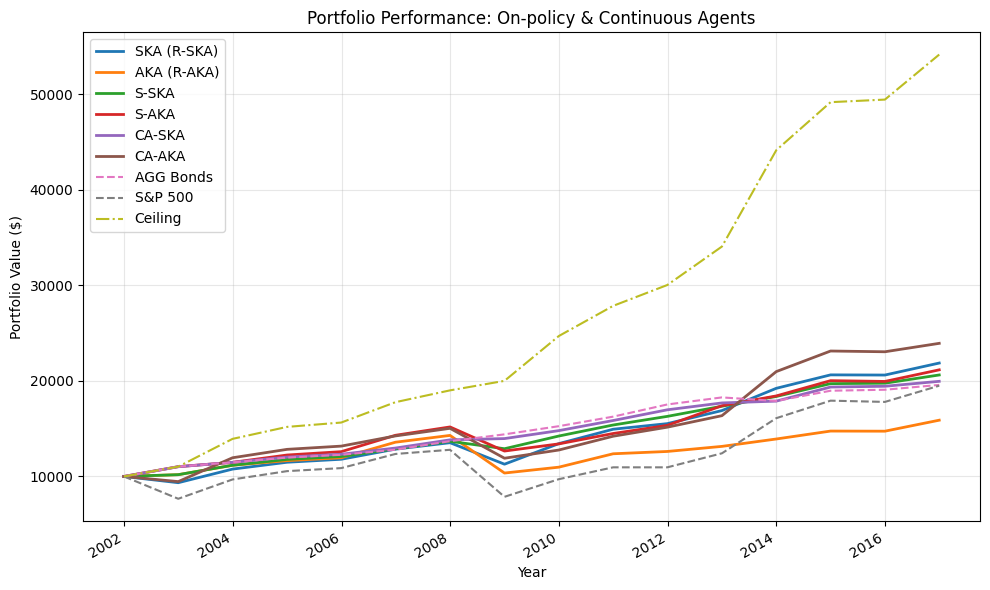

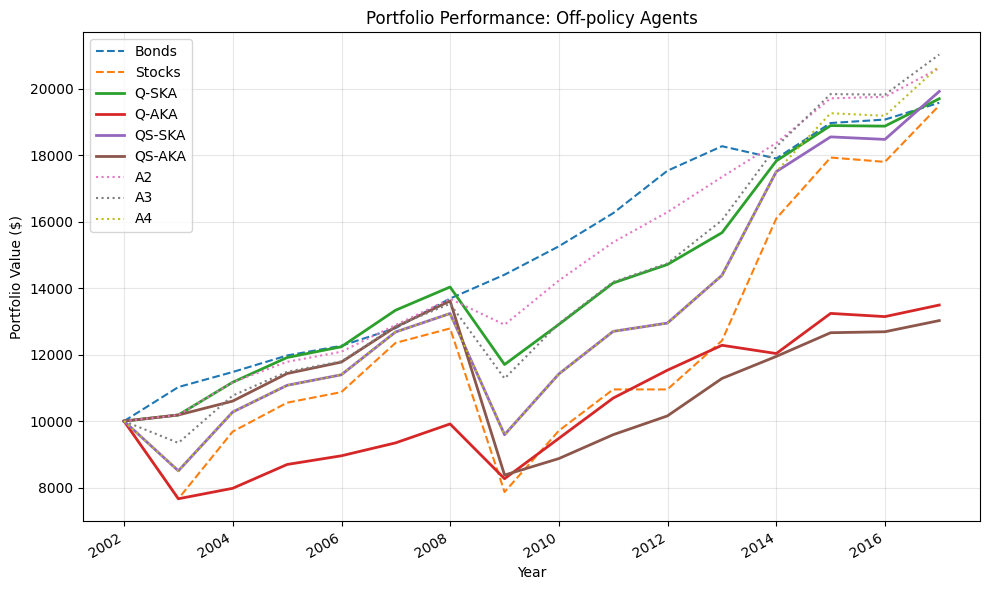

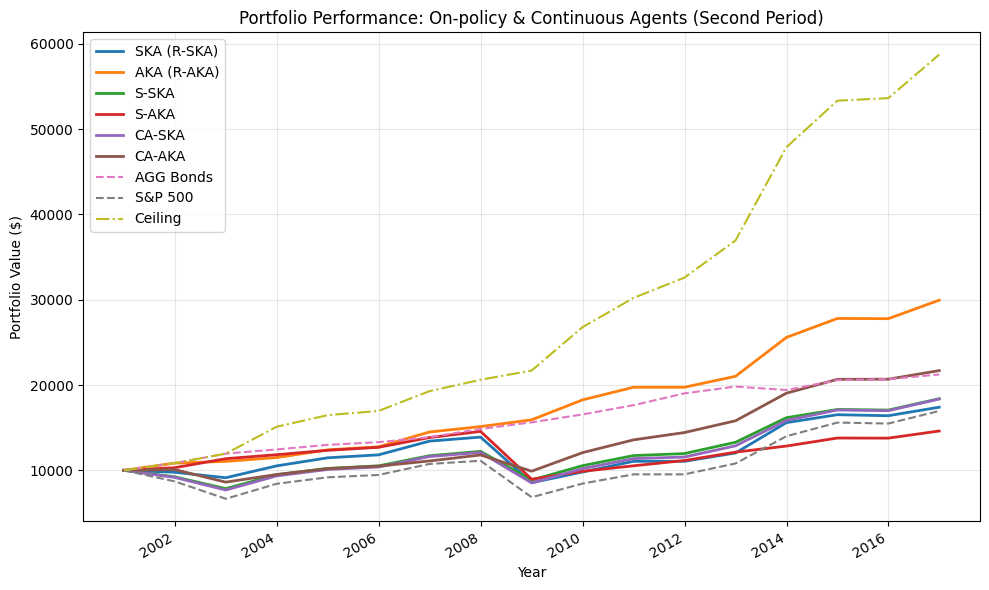

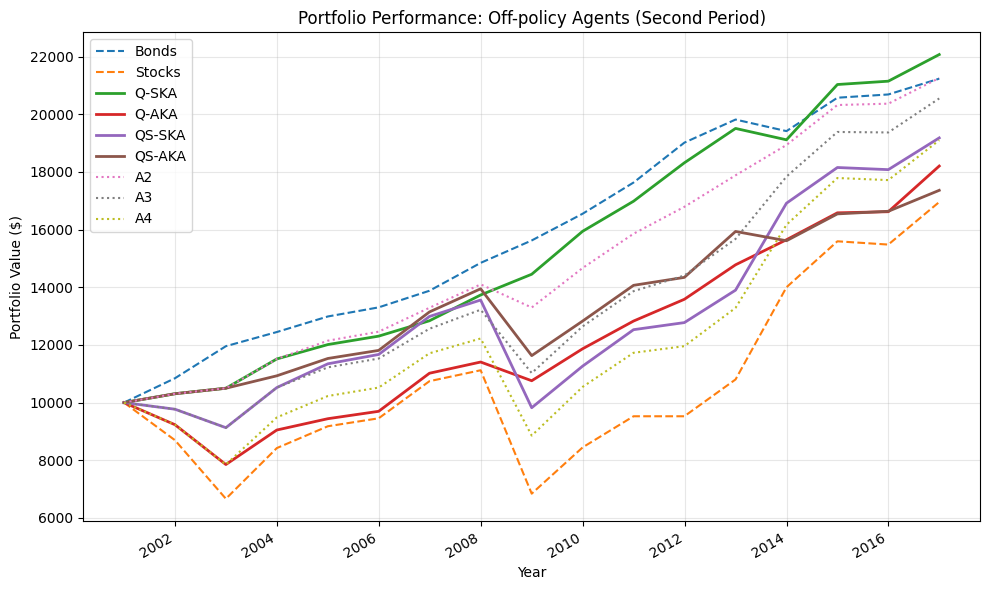

In [12]:
display(fig4, fig5, fig6, fig7)
fig4.savefig(figures_dir + 'ptf1_on_annual_term1.png')
fig5.savefig(figures_dir + 'ptf1_off_annual_term1.png')
fig6.savefig(figures_dir + 'ptf1_on_annual_term2.png')
fig7.savefig(figures_dir + 'ptf1_off_annual_term2.png')

## 4.2 Portfolio 2

The aim of this section is to explore the influence of **trading frequency** on the performance of on-policy and off-policy agents.

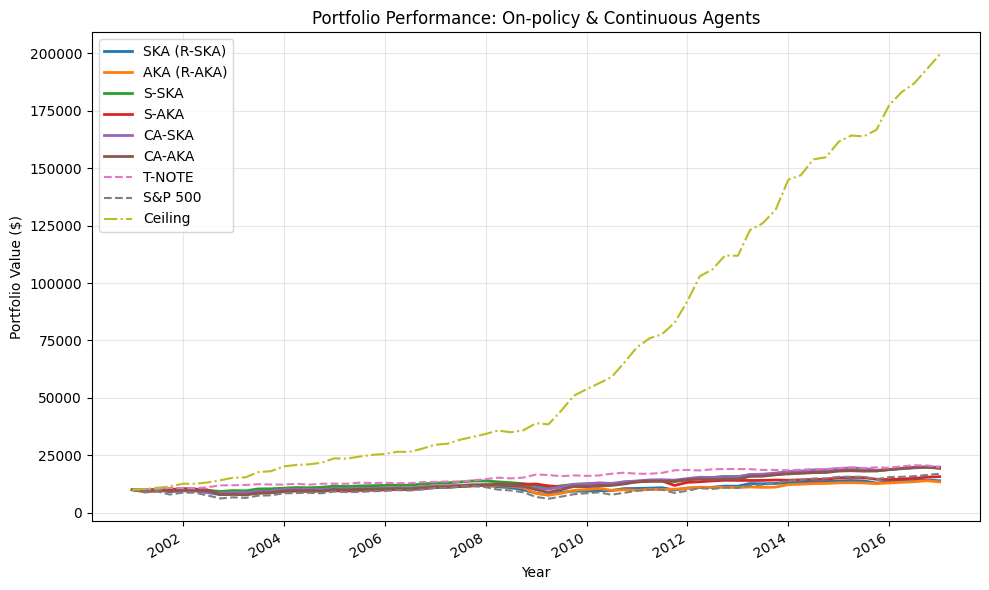

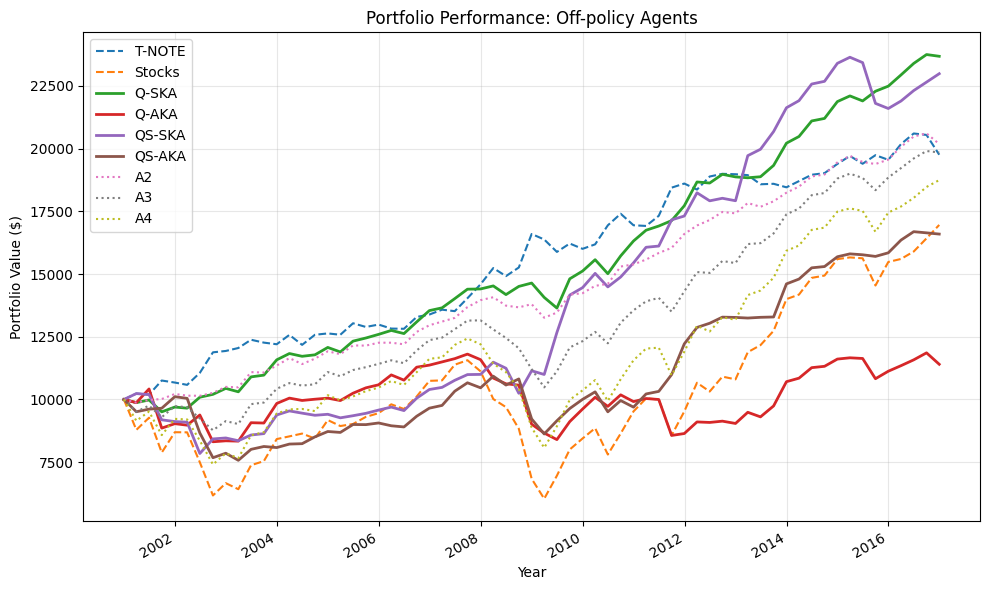

In [13]:
display(HTML('<h2>Fig 8 & 9 :Quarterly Performance</h2>'))
display(fig8, fig9)
fig8.savefig(figures_dir + 'ptf2_on_quarterly.png')
fig9.savefig(figures_dir + 'ptf2_off_quarterly.png')

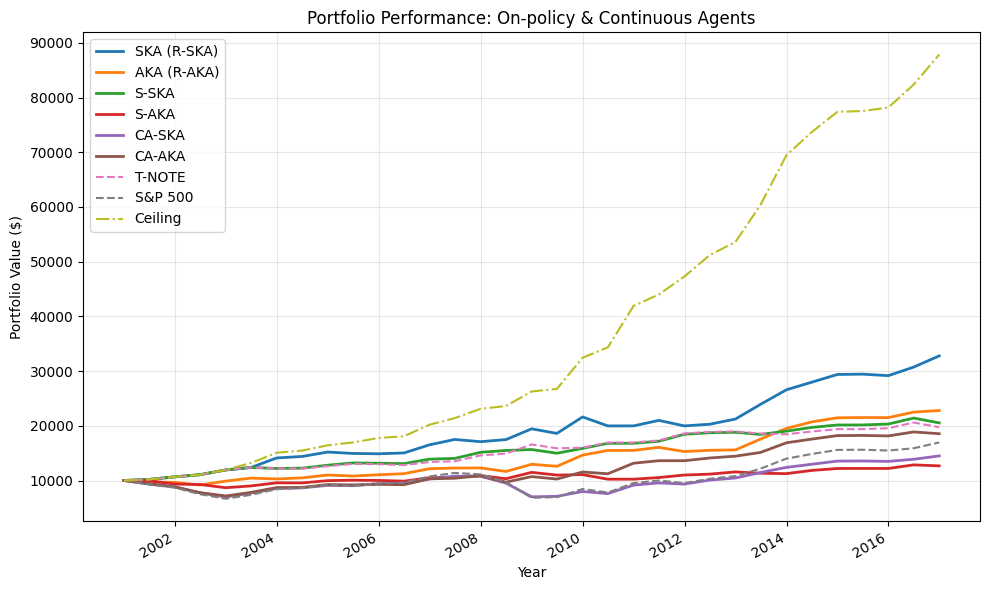

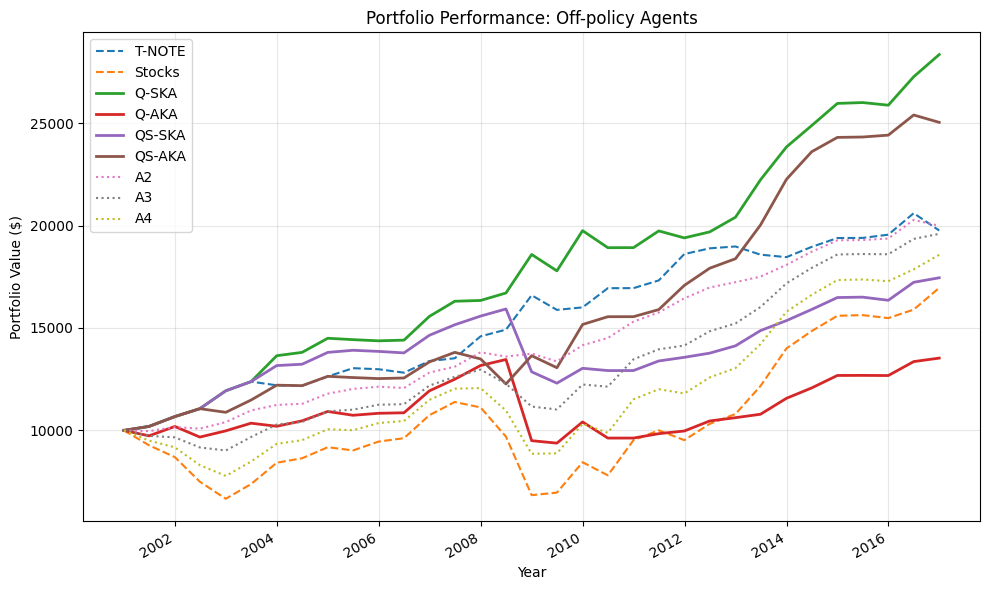

In [14]:
display(HTML('<h2>Fig 10 & 11 :Semi-Annual Performance</h2>'))
display(fig10, fig11)
fig10.savefig(figures_dir + 'ptf2_on_semi_annual.png')
fig11.savefig(figures_dir + 'ptf2_off_semi_annual.png')

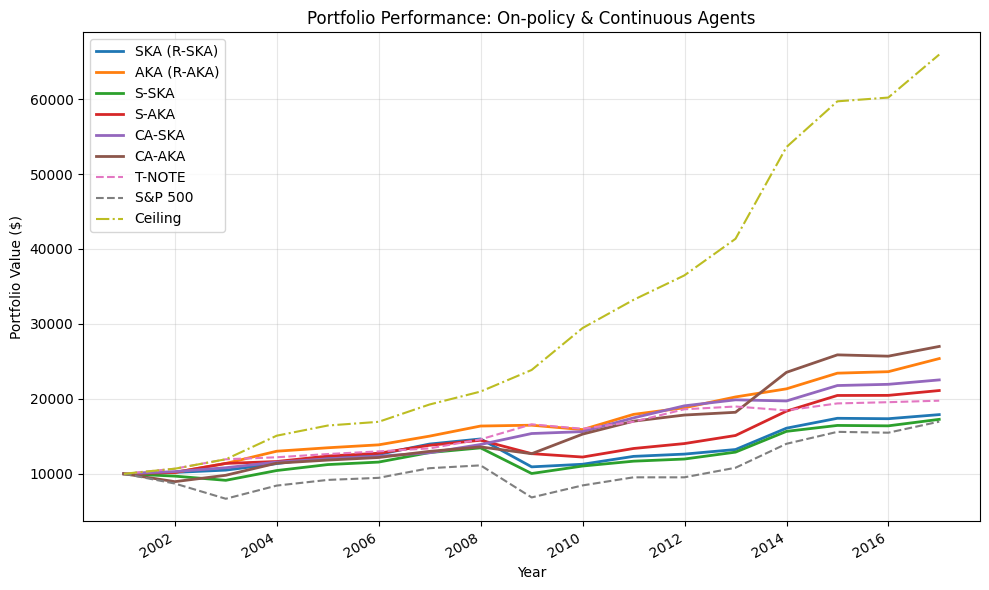

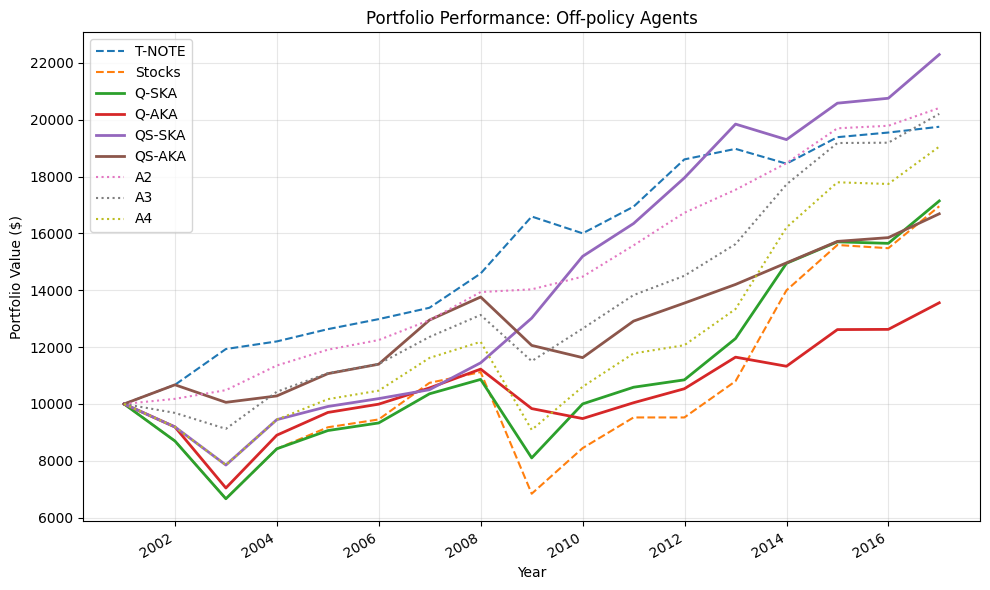

In [15]:
display(HTML('<h2>Fig 12 & 13 :Annual Performance</h2>'))
display(fig12, fig13)
fig12.savefig(figures_dir + 'ptf2_on_annual.png')
fig13.savefig(figures_dir + 'ptf2_off_annual.png')

In [16]:
def plot_grouped_metric(csv_files, metric, fig_type):
    """
    Plots a grouped bar chart for a specified performance metric across 
    different frequencies for a given figure type.
    
    Parameters:
    - csv_files: dict mapping frequency to CSV file path.
    - metric: performance metric to plot (e.g., 'Annualized(%)', 'Sharpe', 'MaxDD').
    - fig_type: "Fig.8" for On-Policy, "Fig.9" for Off-Policy.
    """
    
    # Dictionary to hold data for each frequency
    data_dict = {}
    remove_algorithms = ["T-NOTE", "S&P 500", "Ceiling", "Stocks", "A2", "A3", "A4"]
    for freq, file_path in csv_files.items():
        df = pd.read_csv(file_path)
        df = df[~df["Algorithm"].isin(remove_algorithms)]
        # Filter rows by figure type
        df_filtered = df[df["Figure"] == fig_type].copy()
        # Convert metric values to float
        if metric == 'MaxDD':
            df_filtered[metric] = df_filtered[metric].str.rstrip('%').astype(float) / 100
        else:
            df_filtered[metric] = df_filtered[metric].astype(float)
        # Rename the metric column to include frequency for later merging
        df_filtered = df_filtered[['Algorithm', metric]].rename(columns={metric: f"{metric}_{freq}"})
        data_dict[freq] = df_filtered

    # Find the common algorithms across all frequencies
    common_algorithms = set.intersection(*(set(df['Algorithm']) for df in data_dict.values()))
    if not common_algorithms:
        raise ValueError("No common algorithms found across frequencies. Check data consistency.")
    common_algorithms = sorted(common_algorithms)  # Ensure a consistent order

    # Merge data from all frequencies on 'Algorithm'
    merged_df = None
    for freq, df in data_dict.items():
        df_common = df[df['Algorithm'].isin(common_algorithms)]
        if merged_df is None:
            merged_df = df_common
        else:
            merged_df = pd.merge(merged_df, df_common, on="Algorithm", how="outer")

    # Define the order of frequencies
    ordered_freqs = ['annual', 'semi-annual', 'quarterly']

    # Create grouped bar chart
    x = np.arange(len(common_algorithms))  # X locations for groups
    num_freq = len(ordered_freqs)
    
    # Adjust width and spacing parameters
    width = 0.1  # Wider bars
    group_spacing = 0.05  # Space between bars in the same group
    
    fig, ax = plt.subplots(figsize=(12, 6))
    # Define colors - blue, dark gray, light gray
    colors = {'annual': '#999999', 'semi-annual': '#444444', 'quarterly': 'blue'}

    # Plot a bar for each frequency
    for i, freq in enumerate(ordered_freqs):
        col_name = f"{metric}_{freq}"
        values = merged_df.set_index("Algorithm").loc[common_algorithms][col_name].values
        if len(values) != len(x):
            raise ValueError(f"Length mismatch for frequency '{freq}': expected {len(x)}, got {len(values)}")
        
        # Position bars with spacing between them
        position = x + (i - num_freq/2 + 0.5) * (width + group_spacing)
        ax.bar(position, values, width, label=f"{freq.capitalize()}", 
               color=colors.get(freq, None), alpha=0.8)

    # Update title to show "On-Policy" or "Off-Policy"
    policy_label = "On-Policy" if fig_type == "Fig.8" else "Off-Policy"
    ax.set_xlabel("Algorithm")
    ax.set_ylabel(metric)
    ax.set_title(f"Grouped Comparison of {metric} for {policy_label} (by Frequency)")
    ax.set_xticks(x)
    ax.set_xticklabels(common_algorithms, rotation=45, ha="right")
    ax.legend(title="Frequency")
    ax.grid(axis='y', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(figures_dir + 'freq_' + f'{policy_label}_{metric}.png')
    plt.show()


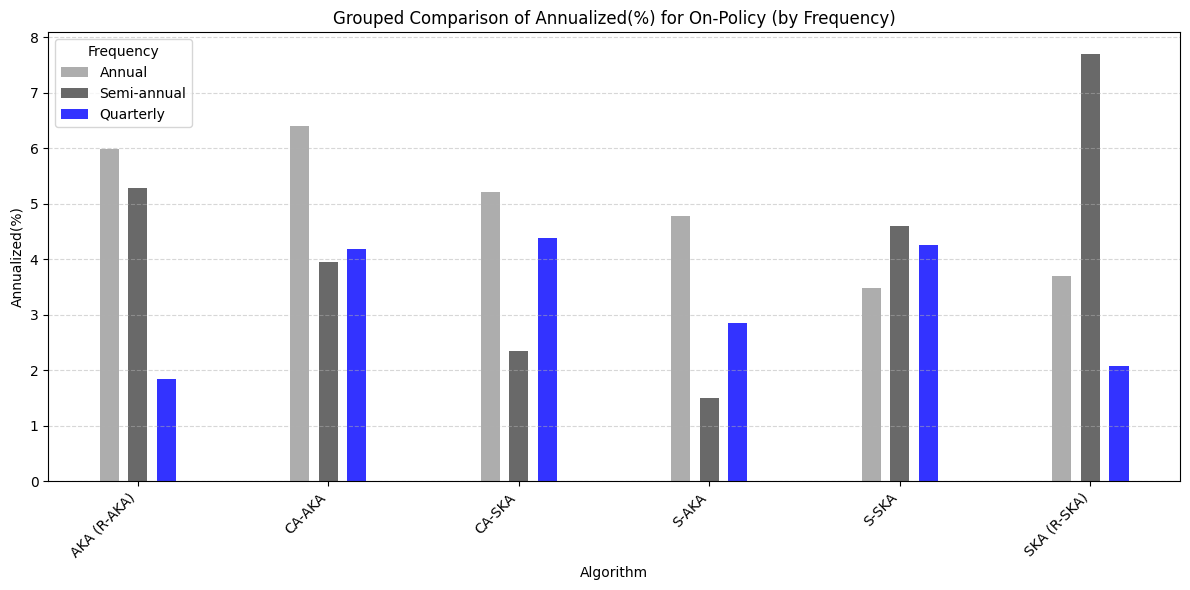

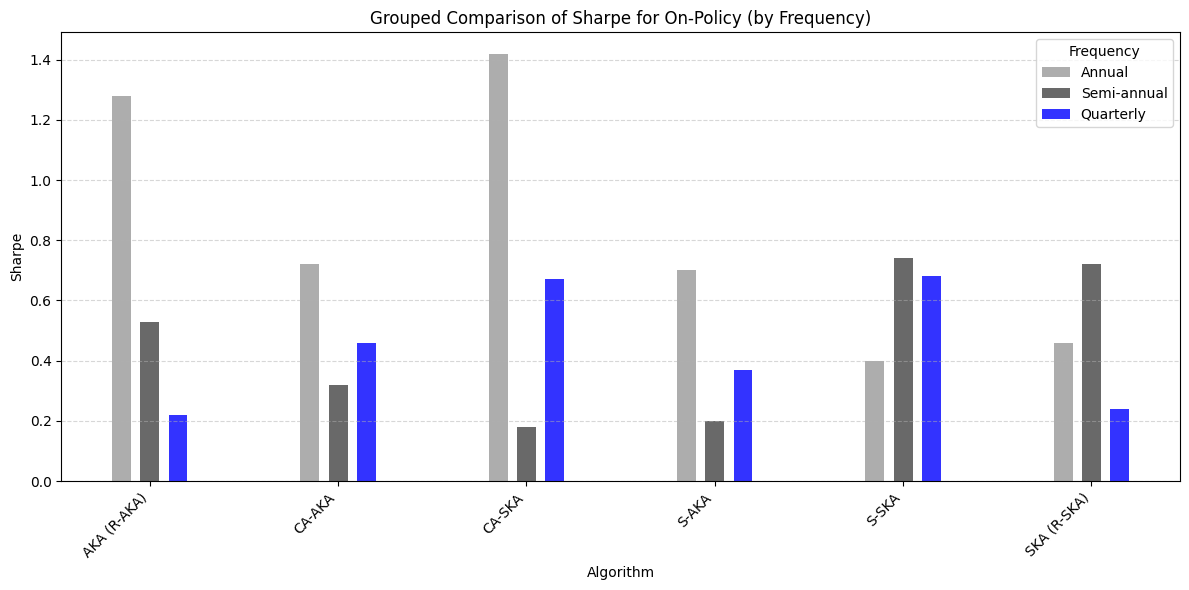

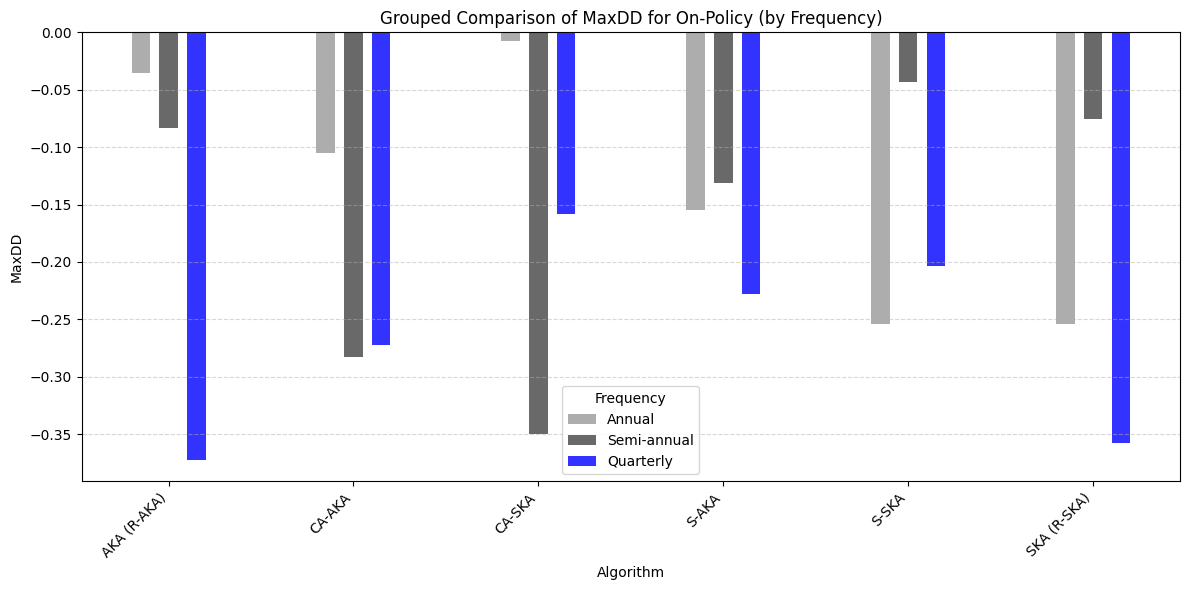

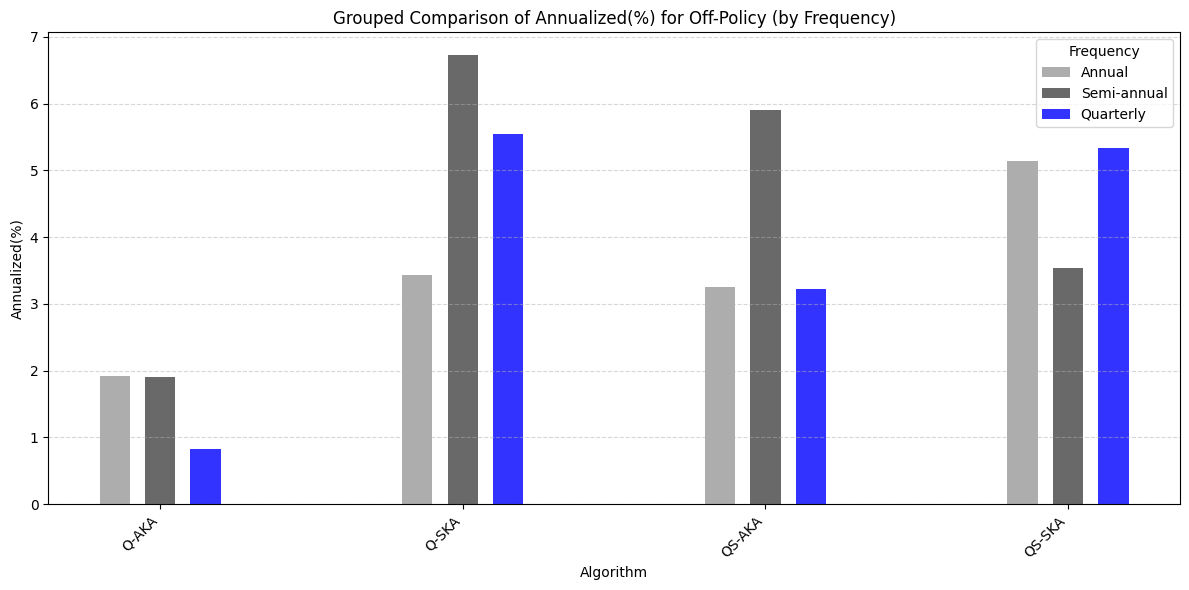

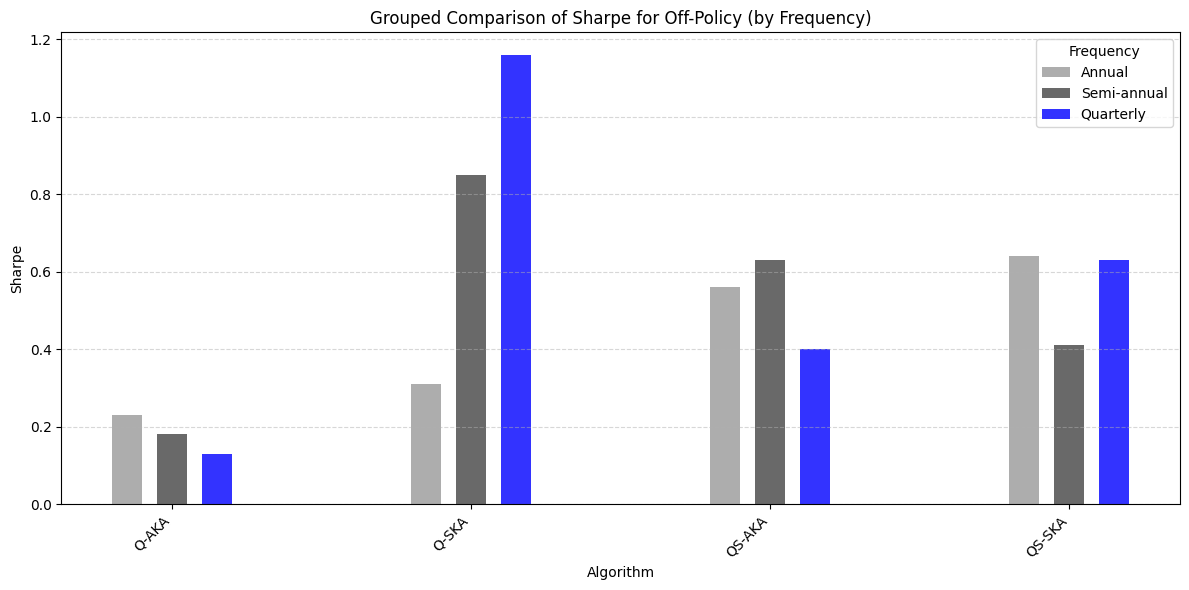

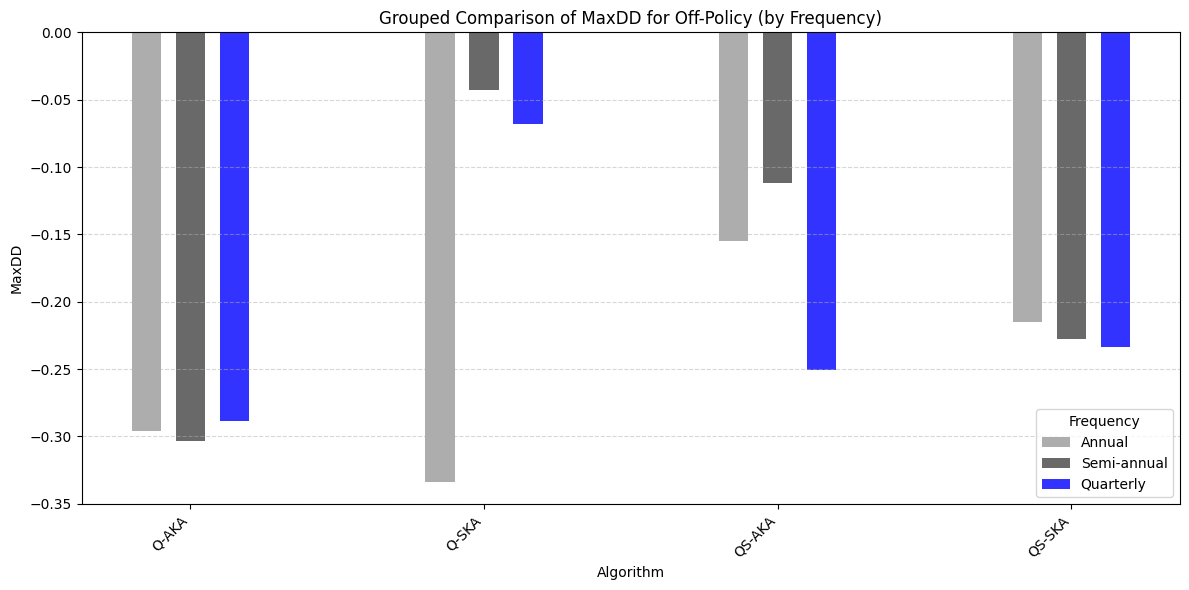

In [21]:

# Load CSV files
csv_files = {
    'annual': table_dir + 'ptf2_annual.csv',
    'semi-annual': table_dir + 'ptf2_semi_annual.csv',
    'quarterly': table_dir + 'ptf2_quarterly.csv'
}

# Automatically plot all six charts
metrics = ["Annualized(%)", "Sharpe", "MaxDD"]
fig_types = ["Fig.8", "Fig.9"]

for fig_type in fig_types:
    for metric in metrics:
        plot_grouped_metric(csv_files, metric, fig_type)
